In [1]:
import geostatspy.GSLIB as GSLIB         
import geostatspy.geostats as geostats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.interpolate import CubicSpline

## Option A debiasing and Simple Kriging Estimate

### Are we in Option A or Option B?

Debiasing of data can be accomplished by incorporating a data trend between primary and secondary variables. The primary data histogram should be consulted in the first instance to understadn wether the dataset has only sampled at either 'high' or 'low' values, based on additional understanding geological or engineering judgement. Debiasing is used when this additional evidence is suggesting that a true distribution has not been collected in the primary dataset, and is potentially missing data from the extemities of the distrbution.

In [2]:
ALL_SPT = pd.read_excel('ALL_SPT.xlsx')
DEM = pd.read_excel('SAMPLE_DEM.xlsx')

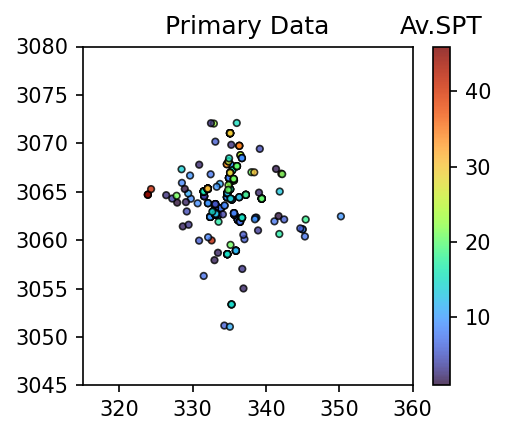

In [3]:
fig, ax = plt.subplots(figsize=(3.5,3),dpi=150)
plt.sca(ax)
ax.set_xlim(315*10**3,360*10**3);ax.set_ylim(3045*10**3,3080*10**3)
ax.ticklabel_format(useOffset=False, style='scientific',axis='both',scilimits=(3,3))
ax.xaxis.offsetText.set_visible(False); ax.yaxis.offsetText.set_visible(False)
ax.set_title('Primary Data')
levels = [0,5,10,15,20,25,30,35,40,45,50]

im = ax.scatter(ALL_SPT['X'],ALL_SPT['Y'],s=10,c=ALL_SPT['ISPT_NVAL'],marker='o',cmap=plt.cm.turbo,alpha=0.8, lw=0.8,ec='k')
cbar = plt.colorbar(im,ax=ax)
cbar.ax.set_title('Av.SPT')
plt.tight_layout()

In this example the full possible range of SPT data (Primary) from 0-50 is avaliable (see historgram below). Therefore this dataset does not require debiasing. We will progress a debias application in any case to present the methodology.

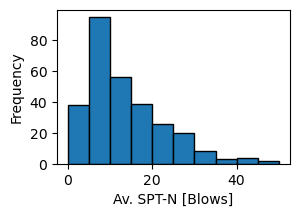

In [4]:
fig, ax = plt.subplots(figsize=(3,2))
plt.sca(ax);
bins = [0,5,10,15,20,25,30,35,40,45,50]
ax.set_xlabel('Av. SPT-N [Blows]'); ax.set_ylabel('Frequency')
counts, values, bars = ax.hist(ALL_SPT['ISPT_NVAL'],ec='k',bins=bins)

#### Option A debiasing

In [5]:
def debiasing_b(m,std,m1,std1,start,stop,start2,binsize2,trend,up2): #for non uniforms bins
    l = np.flip(np.linspace(start,stop,250))
    u = l+(l[0]-l[1])
    bincentre = l+((l[0]-l[1])/2)
    u2=up2
    l2=np.append(start2,u2[:-1])
    sm = norm.cdf(u2,loc=m1,scale=std1) - norm.cdf(l2,loc=m1,scale=std1) #secondary marginal
    bc = (l2 + u2)/2
    biased = np.flip(norm.cdf(u,loc=m,scale=std) - norm.cdf(l,loc=m,scale=std))
    mat1 = {}
    for fm in trend: #fake means
        mat1[fm] = norm.cdf(u,loc=fm,scale=std) - norm.cdf(l,loc=fm,scale=std)
    matrix1 = pd.DataFrame(mat1)
    matrix2 = sm*matrix1  
    debiased = np.flip(np.sum(matrix2,axis=1))
    debiased_cdf = np.cumsum(debiased)/np.max(np.cumsum(debiased))
    gaus = norm.ppf(debiased_cdf,loc=0,scale=1)
       
    return (biased,debiased,np.flip(bincentre),l,debiased_cdf,gaus,matrix1,matrix2)

### Produce trend (use engineering judgement to incorporate new means)
In this example we will use the seccondary source 'elevation data' to debias the data.

In [6]:
#trend must start with naive mean
ALL_SPT['ISPT_NVAL'].mean()

13.653152400020858

#### User defined trend
t2 = SPT trend line values, u2 = elevation trend line values (see blue dots in below)

In [7]:
t2 = np.array([13,20,30,40,50])
u2= np.array([1300,1310,1340,1400,1500])

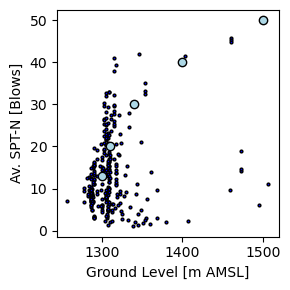

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
plt.sca(ax); ax.set_xlabel('Ground Level [m AMSL]'); ax.set_ylabel('Av. SPT-N [Blows]')
ax.plot(ALL_SPT['LOCA_GL'],ALL_SPT['ISPT_NVAL'],marker='o',mfc='blue',mec='k',lw=0,ms=2)
ax.plot(u2,t2,marker='o',mfc='lightblue',mec='k',lw=0)
plt.tight_layout()

Debias function

In [9]:
b,pdf_z,x,bc_z,cdf_z,Gaus_dist_z,mat1_z,mat2_z = debiasing_b(ALL_SPT['ISPT_NVAL'].mean(),ALL_SPT['ISPT_NVAL'].std(ddof=1),DEM['DEM'].mean(),DEM['DEM'].std(ddof=1),ALL_SPT['ISPT_NVAL'].min(),ALL_SPT['ISPT_NVAL'].max(),900,1,t2,u2)
Debiased = pd.DataFrame({'x':x,'pdf':pdf_z,'cdf':cdf_z,'Gaus':Gaus_dist_z})

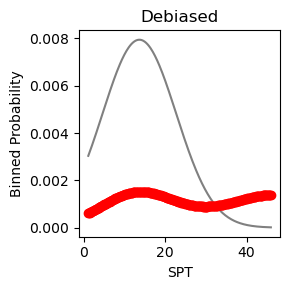

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
plt.title('Debiased')
plt.plot(x,b, marker=None, color='grey', label='SPT-N Biased')
plt.plot(x,pdf_z, marker='o', color='r', label='Unbiased')
ax.set_xlabel('SPT'); ax.set_ylabel('Binned Probability')
plt.tight_layout()

In [11]:
def simple_kriging(df,data_df,param): # debias df, kriging parameter
    #make grid for unknowns (same as in Step 1)
    xmin = 320000; xmax = 356000; ymin = 3050000; ymax = 3077500               
    xran = xmax-xmin; yran = ymax-ymin; xsiz = 1000; ysiz = 1000                   
    x_side = np.linspace(xmin+(0.5*xsiz),xmax-(0.5*xsiz),xran//xsiz)
    y_side = np.linspace(ymin+(0.5*xsiz),ymax-(0.5*ysiz),yran//ysiz)
    X_CELL, Y_CELL = np.meshgrid(x_side,y_side)
    CELL = np.array([np.hstack(X_CELL),np.hstack(Y_CELL)])
    
    #debias x
    f = CubicSpline(df['x'],df['cdf'])
    data_df['CDF'] = f(data_df[param])
    data_df['NVS'] = norm.ppf(data_df['CDF'])
    
    #in vario insert results of using geostatspy variogram creation
    vario = {'nug': 0.0,'nst': 2,'it1': 1,'cc1': 0.9,'azi1': 90,'hmaj1': 4000,'hmin1': 4000,'it2': 1,'cc2': 0.1,'azi2': 90,'hmaj2': 7000,'hmin2': 7000}
    SEP_D = {}; V_M = {}; C_M = {}

    for i,j in zip(range(len(data_df['X'])),range(len(data_df['Y']))):
        SEP_D[i,j] = (np.sqrt((data_df.loc[i]['X']-data_df['X'])**2+(data_df.loc[i]['Y']-data_df['Y'])**2))
        V_M[i,j] = 1.5*SEP_D[i,j]/vario['hmaj1']-(0.5*(SEP_D[i,j]/vario['hmaj1'])**3)
        C_M[i,j] = np.sum(vario['nug']+vario['it1'])-V_M[i,j]

    S = pd.DataFrame(SEP_D.values()); VAR_M = pd.DataFrame(V_M.values()); COV_M = pd.DataFrame(C_M.values())
    I = np.linalg.inv(COV_M.to_numpy())

    DIST = {}; V = {}; C_x = {}
    for unkx,unky in zip(CELL[0],CELL[1]):
        DIST[unkx,unky] = {}; V[unkx,unky] = {}; C_x[unkx,unky] = {}
        for x,y in zip(data_df['X'],data_df['Y']):
            DIST[unkx,unky][x,y] = np.sqrt((x-unkx)**2+(y-unky)**2)
            V[unkx,unky][x,y] =  1.5*DIST[unkx,unky][x,y]/vario['hmaj1']-(0.5*(DIST[unkx,unky][x,y]/vario['hmaj1'])**3)
            C_x[unkx,unky][x,y] = np.sum(vario['nug']+vario['it1'])-V[unkx,unky][x,y]
    
    WEIGHT_DF = {}; Simp_krig = {}; Krig_var = {}
    for c in C_x.keys():
        WEIGHT_DF[c] = pd.DataFrame(data_df)
        WEIGHT_DF[c]['Weights'] = I@np.array(list(C_x[c].values()))
        WEIGHT_DF[c]['residual'] = WEIGHT_DF[c]['NVS']
        WEIGHT_DF[c]['R+W'] = WEIGHT_DF[c]['residual'] * WEIGHT_DF[c]['Weights']
        Simp_krig[c] = np.sum(WEIGHT_DF[c]['R+W'])
        Krig_var[c] = np.sum(vario['nug']+vario['it1']) - np.sum((WEIGHT_DF[c]['Weights']*list(C_x[c].values()))) 
    
    #backtransform
    KRIG = pd.DataFrame(data=Simp_krig.values(),index=Simp_krig.keys()).reset_index().rename(columns={'level_0':'X_UNK','level_1':'Y_UNK',0:'gaus'}).set_index(['X_UNK','Y_UNK'])
    KRIG['cdf'] = norm.cdf(KRIG['gaus'])
    x, i = np.unique(df['cdf'],return_index=True)
    cs = CubicSpline(df['cdf'].iloc[i],df['x'].iloc[i])
    KRIG['param'] = cs(KRIG['cdf'])
    VAR = pd.DataFrame(data=Krig_var.values(),index=Krig_var.keys()).reset_index().rename(columns={'level_0':'X_UNK','level_1':'Y_UNK',0:'Var'}).set_index(['X_UNK','Y_UNK'])
    SIMPLE_KRIG = KRIG.join(VAR).reset_index()
    KRIG = KRIG.reset_index()
    X = KRIG['X_UNK'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    Y = KRIG['Y_UNK'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    param = KRIG['param'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    return (SIMPLE_KRIG,X,Y,param)

In [12]:
KRIG,X,Y,param = simple_kriging(Debiased,ALL_SPT,'ISPT_NVAL')

Text(0.5, 1.0, 'Av.SPT')

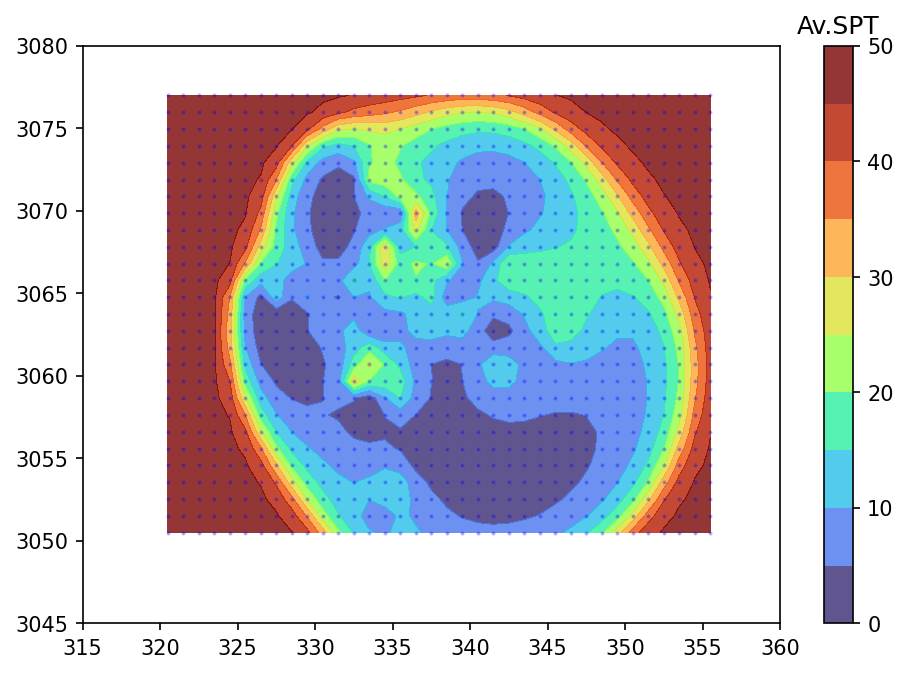

In [13]:
fig, ax = plt.subplots(figsize=(7.5,5),dpi=150)
plt.sca(ax); ax.set_xlim(315*10**3,360*10**3);ax.set_ylim(3045*10**3,3080*10**3)
ax.ticklabel_format(useOffset=False, style='scientific',axis='both',scilimits=(3,3))
ax.xaxis.offsetText.set_visible(False); ax.yaxis.offsetText.set_visible(False)

norm1 = mpl.colors.Normalize(vmin=0,vmax=50); levels = [0,5,10,15,20,25,30,35,40,45,50]
ax.plot(X,Y,marker='o',color='b',lw=0,ms=1,alpha=0.25)
cp = plt.contourf(X,Y,param,levels=[0,5,10,15,20,25,30,35,40,45,50],cmap=plt.cm.turbo, norm=norm1, vmin=1, vmax=46,alpha=0.8)
cbar = plt.colorbar(cp,ax=ax)
cbar.ax.set_title('Av.SPT')

In [14]:
KRIG.to_excel('2.1_Primary_SPT.xlsx')

### Multi-krig

In [15]:
f = CubicSpline(Debiased['x'],Debiased['cdf'])
ALL_SPT['N_ISPT'] = norm.ppf(f(ALL_SPT['ISPT_NVAL']))
ALL_SPT['N_DEM'] = (ALL_SPT['LOCA_GL'] - np.mean(ALL_SPT['LOCA_GL']))/np.std(ALL_SPT['LOCA_GL'],ddof=1)

In [16]:
DEM['NDEM'], tvus, tnsus = geostats.nscore(DEM, 'DEM')
DEM_raster = DEM['NDEM'].to_numpy().reshape(27,36) #  equal to X_CELL.shape[0],X_CELL.shape[1]

Update shape based on the chosen grid sizing

In [17]:
left = ALL_SPT.loc[:,['N_DEM']].corr().values
right = np.asarray([ALL_SPT.loc[:,'N_ISPT'].corr(ALL_SPT.loc[:,'N_DEM'])])

left_inv = np.linalg.inv(left)
wts = left_inv @ right
smean = DEM_raster * wts[0]
svar = np.full(shape=(27,36),fill_value=(1-wts[0]*right[0]))

Prim_mean = KRIG['gaus'].to_numpy().reshape(27,36)
Prim_var = KRIG['Var'].to_numpy().reshape(27,36)
postmean = (smean * Prim_var + Prim_mean * svar) / (Prim_var-Prim_var*svar + svar)
postvar = (Prim_var*svar) / (Prim_var-Prim_var*svar + svar)

x, i = np.unique(Debiased['cdf'],return_index=True)
cs = CubicSpline(Debiased['cdf'].iloc[i],Debiased['x'].iloc[i])
bkpost = np.reshape(cs(norm.cdf(postmean.flatten())),(27,36))
KRIG['Secondarymean'] = smean.flatten(); KRIG['svar'] = svar.flatten(); KRIG['Postmean'] = bkpost.flatten(); KRIG['Postvar'] = postvar.flatten()
X = KRIG['X_UNK'].to_numpy().reshape(27,36)
Y = KRIG['Y_UNK'].to_numpy().reshape(27,36)

Text(0.5, 1.0, 'Av.SPT')

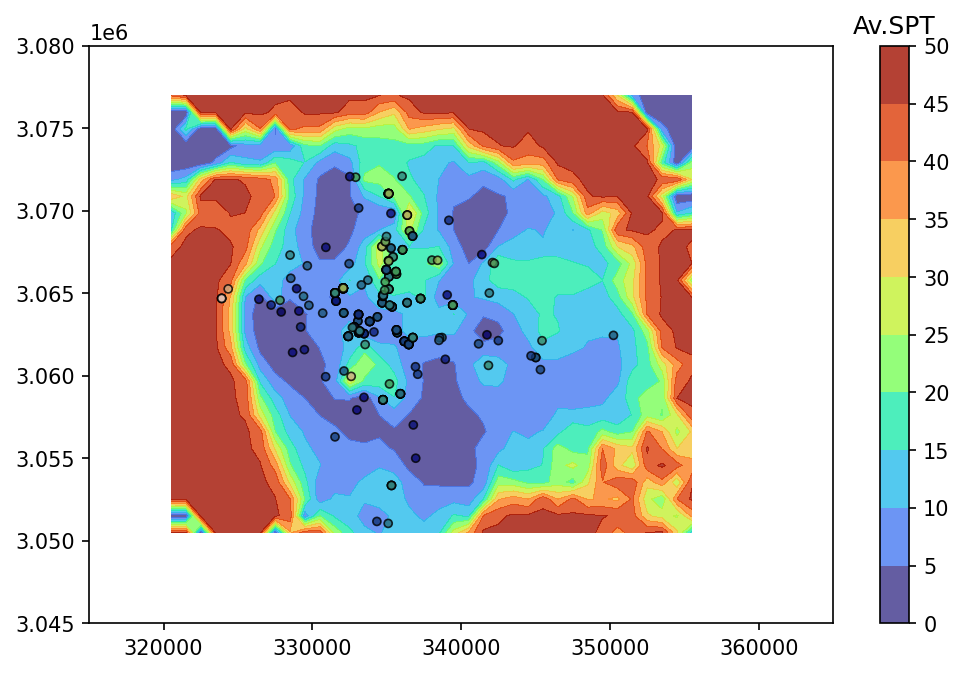

In [18]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
plt.sca(ax); ax.set_xlim(315*10**3,365*10**3);ax.set_ylim(3045*10**3,3080*10**3)
norm1 = mpl.colors.Normalize(vmin=0,vmax=50); levels = [0,5,10,15,20,25,30,35,40,45,50]

cp = plt.contourf(X,Y,bkpost,levels=levels,cmap=plt.cm.turbo, norm=norm1,alpha=0.8)
im = ax.scatter(ALL_SPT['X'],ALL_SPT['Y'],s=15, c=ALL_SPT['ISPT_NVAL'], marker='o', cmap=plt.cm.gist_earth, norm=norm1, alpha=0.8, linewidths=0.8, edgecolors="black")
cbar = plt.colorbar(cp,ax=ax,ticks=levels)
cbar.ax.set_title('Av.SPT')

In [19]:
KRIG.to_excel('2.1_Multi_Krig.xlsx')